# Description

This architecture was described in "Deep learning with convolutional neural networks for brain mapping and decoding of movement-related information from the human EEG", by R. T. Schirrmeister et al, 2018. In this notebook we conduct experiments showing dependency between accuracy and the number of timestamps in a sample. 

# Set up the environment

In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# import tf
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K

# import os functions
import os
import time

import numpy as np
import matplotlib.pyplot as plt

from IPython import display

# Load the data

### Read the files

In [47]:
X_test = np.load("./EEG_data/X_test.npy")
y_test = np.load("./EEG_data/y_test.npy") - 769
person_train_valid = np.load("./EEG_data/person_train_valid.npy")
X_train_valid = np.load("./EEG_data/X_train_valid.npy")
y_train_valid = np.load("./EEG_data/y_train_valid.npy") - 769
person_test = np.load("./EEG_data/person_test.npy")

### Shape of data

In [4]:
print("training/Valid data shape: {}".format(X_train_valid.shape))       # training data of many persons
print("Test data shape: {}".format(X_test.shape))                        # test data of many persons
print("Training/Valid target shape: {}".format(y_train_valid.shape))     # training labels of many persons
print("Test target shape: {}".format(y_test.shape))                      # test labels of many persons
print("Person train/valid  shape: {}".format(person_train_valid.shape))  # which person correspond to the trail in test set
print("Person test shape: {}".format(person_test.shape))                 # which person correspond to the trail in test set

training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid  shape: (2115, 1)
Person test shape: (443, 1)


### divide dataset into training and validation

In [48]:
perm = np.random.permutation(X_train_valid.shape[0])
num_train = int(0.8 * X_train_valid.shape[0])
num_valid = X_train_valid.shape[0] - num_train
X_train =  X_train_valid[perm[0:num_train]]
y_train =  y_train_valid[perm[0:num_train]]
X_valid = X_train_valid[perm[num_train: ]]
y_valid = y_train_valid[perm[num_train: ]]


print("Training data shape: {}".format(X_train.shape))
print("Training label shape: {}".format(y_train.shape))
print("Validation data shape: {}".format(X_valid.shape))
print("Validation label shape: {}".format(y_valid.shape))
print("Test data shape: {}".format(X_test.shape))
print("Test label shape: {}".format(y_test.shape))

Training data shape: (1692, 22, 1000)
Training label shape: (1692,)
Validation data shape: (423, 22, 1000)
Validation label shape: (423,)
Test data shape: (443, 22, 1000)
Test label shape: (443,)


### Preprocess data

In [6]:
def sliding_window(X_arr, y_arr, time_window=100, time_step=1, time_stride=1):
    temp_x = np.moveaxis(X_arr, 2, 0)
    temp_x = temp_x.astype(np.float32)
    buff = []
    
    num_slices = (len(temp_x)-time_window*time_step) // time_stride + 1
    
    # get time slices for data
    for i in range(num_slices):
        buff.append(temp_x[i*time_stride:i*time_stride + time_window*time_step:time_step])
        buff[i] = np.moveaxis(buff[i], 0, 2)
        # uncomment this if additional dimension is needed
        # buff[i] = buff[i].reshape(1, buff[i].shape[0], buff[i].shape[1], buff[i].shape[2])
        
    temp_x = np.concatenate(buff)
        
    # get time slice for labels
    temp_y = np.ones((X_arr.shape[0],num_slices))
    
    for i in range(len(y_arr)):
        temp_y[i] = temp_y[i] * y_arr[i]
        
    temp_y = temp_y.reshape((-1))
    
    return temp_x, temp_y

# Experiment 1: shallow model 

In this experiment we show that:
1. shallow model can achieve 61% of validation accuracy given samples with 1000 timestamps;
2. shallow model achieves peak validation accuracy after being trained for 12 epochs, after which it starts to overfit.

### define activation functions

In [7]:
def Ksquare(x):
    return K.pow(x, 2)

def Klog(x):
    return K.log(x)

### Construct model

In [35]:
def construct_shallow_model(TIME_WINDOW):
    # input
    shallow_input = layers.Input(shape=(22, TIME_WINDOW))

    # conv accross time domain
    r1 = layers.Reshape((22, TIME_WINDOW, 1))(shallow_input)
    c1 = layers.Conv2D(40, (1, 25), strides=(1, 1), activation="elu")(r1)
    new_size = TIME_WINDOW - 25 + 1
    t1 = tf.keras.layers.Permute((2, 3, 1))(c1)
    
    
    # conv accross time domain
    r2 = layers.Reshape((new_size, 40*22, 1))(t1)
    c2 = layers.Conv2D(40, (1, 40*22), strides=(1, 1), activation="elu")(r2)

    sq1 = layers.Activation(Ksquare)(c2)
    r3 = layers.Reshape((new_size, 40, 1))(sq1)
    apool1 = layers.AveragePooling2D(pool_size=(75, 1), strides=(15, 1))(r3)

    log1 = layers.Activation(Klog)(apool1)
    f1 = layers.Flatten()(log1)

    # output
    shallow_output = layers.Dense(4, activation="softmax")(f1)
    
    return keras.Model(inputs = shallow_input, outputs = shallow_output)

In [16]:
shallow_model_1000 = construct_shallow_model(1000)
shallow_model_1000.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

In [17]:
shallow_model_1000.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 22, 1000)]        0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 22, 1000, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 976, 40)       1040      
_________________________________________________________________
permute_1 (Permute)          (None, 976, 40, 22)       0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 976, 880, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 976, 1, 40)        35240     
_________________________________________________________________
activation_2 (Activation)    (None, 976, 1, 40)        0   

### Make checkpoints

In [18]:
# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/shallow_model_1000',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

### Train model

In [19]:
shallow_model_loss_hist = shallow_model_1000.fit(X_train, y_train,
                                                 validation_data = (X_valid, y_valid),
                                                 epochs = 15,
                                                 callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/15
1664/1692 [============================>.] - ETA: 0s - loss: 1.8517 - acc: 0.3047
Epoch 00001: val_loss improved from inf to 1.43534, saving model to ./model_checkpoints/shallow_model_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_1000\assets
1692/1692 [==============================] - 21s 12ms/sample - loss: 1.8460 - acc: 0.3026 - val_loss: 1.4353 - val_acc: 0.2908
Epoch 2/15
1664/1692 [============================>.] - ETA: 0s - loss: 1.2931 - acc: 0.4032
Epoch 00002: val_loss improved from 1.43534 to 1.34584, saving model to ./model_checkpoints/shallow_model_1000
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_1000\assets
1692/1692 [==============================] - 22s 13ms/sample - loss: 1.2937 - acc: 0.4031 - val_loss: 1.3458 - val_acc: 0.3546
Epoch 3/15
1664/1692 [============================>.] - ETA: 0s - loss: 1.1751 - acc: 0.4880
Epoch 00003: val_loss improved from 1.34

### Produce graphs

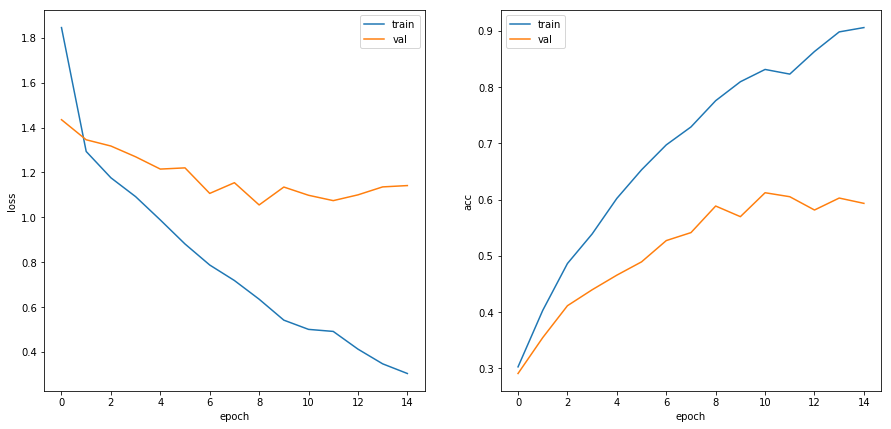

In [20]:
hist = shallow_model_loss_hist.history

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1, 2, 2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

# Experiment 2: shallow model with normilized data.

In this experiment we shaow that data normalization does not help to improve validation accuracy. For the following experiment with shallow model, we do not try to normilize data.

### Prepare data

In [26]:
# normilize the data USING ONLY TRAIN DATA MEAN AND STANDARD DEVIATION
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)
X_valid_norm = (X_valid - np.mean(X_train))/np.std(X_train)
X_test_norm = (X_test - np.mean(X_train))/np.std(X_train)

### Construct model

In [27]:
shallow_model_1000_norm = construct_shallow_model(1000)
shallow_model_1000_norm.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

### Make checkpoints

In [28]:
# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/shallow_model_1000_norm',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]

### Train model

In [30]:
shallow_model_1000_norm.fit(X_train_norm, y_train,
                            validation_data = (X_valid_norm, y_valid),
                            epochs = 15,
                            callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/15
1692/1692 [==============================] - 21s 12ms/sample - loss: 2.7574 - acc: 0.2683 - val_loss: 1.5336 - val_acc: 0.2931
Epoch 2/15
1692/1692 [==============================] - 22s 13ms/sample - loss: 1.3980 - acc: 0.3387 - val_loss: 1.4137 - val_acc: 0.3215
Epoch 3/15
1692/1692 [==============================] - 20s 12ms/sample - loss: 1.3183 - acc: 0.3818 - val_loss: 1.3911 - val_acc: 0.3522
Epoch 4/15
1692/1692 [==============================] - 20s 12ms/sample - loss: 1.2948 - acc: 0.4072 - val_loss: 1.3900 - val_acc: 0.3357
Epoch 5/15
1692/1692 [==============================] - 20s 12ms/sample - loss: 1.2434 - acc: 0.4297 - val_loss: 1.3935 - val_acc: 0.3522
Epoch 6/15
1692/1692 [==============================] - 20s 12ms/sample - loss: 1.2194 - acc: 0.4527 - val_loss: 1.3943 - val_acc: 0.3593
Epoch 7/15
1692/1692 [==============================] - 20s 12ms/sample - loss: 1.1908 - acc: 0.4740 - val_loss: 1.4091 - val

In [31]:
shallow_model_1000_norm.fit(X_train_norm, y_train,
                            validation_data = (X_valid_norm, y_valid),
                            epochs = 10,
                            callbacks=checkpoint_callback)

Train on 1692 samples, validate on 423 samples
Epoch 1/10
1692/1692 [==============================] - 20s 12ms/sample - loss: 0.7886 - acc: 0.6814 - val_loss: 1.1313 - val_acc: 0.5508
Epoch 2/10
1692/1692 [==============================] - 20s 12ms/sample - loss: 0.7274 - acc: 0.7281 - val_loss: 1.1775 - val_acc: 0.5366
Epoch 3/10
1692/1692 [==============================] - 21s 13ms/sample - loss: 0.6945 - acc: 0.7364 - val_loss: 1.1211 - val_acc: 0.5437
Epoch 4/10
1692/1692 [==============================] - 20s 12ms/sample - loss: 0.6469 - acc: 0.7571 - val_loss: 1.0982 - val_acc: 0.5579
Epoch 5/10
1692/1692 [==============================] - 20s 12ms/sample - loss: 0.6145 - acc: 0.7707 - val_loss: 1.0945 - val_acc: 0.5485
Epoch 6/10
1692/1692 [==============================] - 20s 12ms/sample - loss: 0.5804 - acc: 0.7807 - val_loss: 1.1278 - val_acc: 0.5650
Epoch 7/10
1692/1692 [==============================] - 20s 12ms/sample - loss: 0.5631 - acc: 0.7837 - val_loss: 1.0588 - val

# Experiment 3: shallow model - accuracy vs number of timestamps 

### Train models

In [38]:
TIME_WINDOW = 300
TIME_STRIDE = 1000

# cut the slices
X_train_slices, y_train_slices = sliding_window(X_train, 
                                                y_train, 
                                                time_window=TIME_WINDOW,  
                                                time_stride=TIME_STRIDE)


X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=TIME_WINDOW, 
                                                time_stride=TIME_STRIDE)


print("Training data shape with slices: {}".format(X_train_slices.shape))
print("Training label shape with slice: {}".format(y_train_slices.shape))
print("Validation data shape with slices: {}".format(X_valid_slices.shape))
print("Validation label shape with slice: {}".format(y_valid_slices.shape))


# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/shallow_model_' + str(TIME_WINDOW),
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


shallow_model_300 = construct_shallow_model(TIME_WINDOW)
shallow_model_300.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

shallow_model_300.fit(X_train_slices, y_train_slices,
                      validation_data = (X_valid_slices, y_valid_slices),
                      epochs = 30,
                      callbacks=checkpoint_callback)

Training data shape with slices: (1692, 22, 300)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 300)
Validation label shape with slice: (423,)
Train on 1692 samples, validate on 423 samples
Epoch 1/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.5946 - acc: 0.2867
Epoch 00001: val_loss improved from inf to 1.36080, saving model to ./model_checkpoints/shallow_model_300
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_300\assets
1692/1692 [==============================] - 7s 4ms/sample - loss: 1.5923 - acc: 0.2866 - val_loss: 1.3608 - val_acc: 0.3546
Epoch 2/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.3122 - acc: 0.3924
Epoch 00002: val_loss did not improve from 1.36080
1692/1692 [==============================] - 6s 4ms/sample - loss: 1.3115 - acc: 0.3948 - val_loss: 1.3750 - val_acc: 0.3215
Epoch 3/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.2518 - acc: 0.4399
Epoch

Epoch 26/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.3146 - acc: 0.9117
Epoch 00026: val_loss did not improve from 0.96790
1692/1692 [==============================] - 6s 3ms/sample - loss: 0.3133 - acc: 0.9131 - val_loss: 1.1607 - val_acc: 0.5697
Epoch 27/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.3068 - acc: 0.9183
Epoch 00027: val_loss did not improve from 0.96790
1692/1692 [==============================] - 6s 3ms/sample - loss: 0.3091 - acc: 0.9161 - val_loss: 1.0767 - val_acc: 0.6123
Epoch 28/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.2732 - acc: 0.9303
Epoch 00028: val_loss did not improve from 0.96790
1692/1692 [==============================] - 6s 3ms/sample - loss: 0.2750 - acc: 0.9285 - val_loss: 1.2377 - val_acc: 0.6147
Epoch 29/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.2586 - acc: 0.9273
Epoch 00029: val_loss did not improve from 0.96790
1692/1692 [==============================] - 

In [39]:
TIME_WINDOW = 500
TIME_STRIDE = 1000

# cut the slices
X_train_slices, y_train_slices = sliding_window(X_train, 
                                                y_train, 
                                                time_window=TIME_WINDOW,  
                                                time_stride=TIME_STRIDE)


X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=TIME_WINDOW, 
                                                time_stride=TIME_STRIDE)


print("Training data shape with slices: {}".format(X_train_slices.shape))
print("Training label shape with slice: {}".format(y_train_slices.shape))
print("Validation data shape with slices: {}".format(X_valid_slices.shape))
print("Validation label shape with slice: {}".format(y_valid_slices.shape))


# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/shallow_model_' + str(TIME_WINDOW),
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


shallow_model_500 = construct_shallow_model(TIME_WINDOW)
shallow_model_500.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

shallow_model_500.fit(X_train_slices, y_train_slices,
                      validation_data = (X_valid_slices, y_valid_slices),
                      epochs = 30,
                      callbacks=checkpoint_callback)

Training data shape with slices: (1692, 22, 500)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 500)
Validation label shape with slice: (423,)
Train on 1692 samples, validate on 423 samples
Epoch 1/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.6477 - acc: 0.3221
Epoch 00001: val_loss improved from inf to 1.38288, saving model to ./model_checkpoints/shallow_model_500
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_500\assets
1692/1692 [==============================] - 10s 6ms/sample - loss: 1.6453 - acc: 0.3203 - val_loss: 1.3829 - val_acc: 0.3759
Epoch 2/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.2595 - acc: 0.4309
Epoch 00002: val_loss improved from 1.38288 to 1.25625, saving model to ./model_checkpoints/shallow_model_500
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_500\assets
1692/1692 [==============================] - 10s 6ms/sample - loss: 1.2624 - acc: 0

1664/1692 [============================>.] - ETA: 0s - loss: 0.1393 - acc: 0.9760
Epoch 00026: val_loss did not improve from 0.94221
1692/1692 [==============================] - 10s 6ms/sample - loss: 0.1402 - acc: 0.9752 - val_loss: 1.1916 - val_acc: 0.6052
Epoch 27/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.1309 - acc: 0.9772
Epoch 00027: val_loss did not improve from 0.94221
1692/1692 [==============================] - 10s 6ms/sample - loss: 0.1301 - acc: 0.9775 - val_loss: 1.2355 - val_acc: 0.5887
Epoch 28/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.1097 - acc: 0.9838
Epoch 00028: val_loss did not improve from 0.94221
1692/1692 [==============================] - 10s 6ms/sample - loss: 0.1108 - acc: 0.9835 - val_loss: 1.1930 - val_acc: 0.6123
Epoch 29/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0992 - acc: 0.9874
Epoch 00029: val_loss did not improve from 0.94221
1692/1692 [==============================] - 10s 6ms/s

In [40]:
TIME_WINDOW = 600
TIME_STRIDE = 1000

# cut the slices
X_train_slices, y_train_slices = sliding_window(X_train, 
                                                y_train, 
                                                time_window=TIME_WINDOW,  
                                                time_stride=TIME_STRIDE)


X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=TIME_WINDOW, 
                                                time_stride=TIME_STRIDE)


print("Training data shape with slices: {}".format(X_train_slices.shape))
print("Training label shape with slice: {}".format(y_train_slices.shape))
print("Validation data shape with slices: {}".format(X_valid_slices.shape))
print("Validation label shape with slice: {}".format(y_valid_slices.shape))


# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/shallow_model_' + str(TIME_WINDOW),
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


shallow_model_600 = construct_shallow_model(TIME_WINDOW)
shallow_model_600.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

shallow_model_600.fit(X_train_slices, y_train_slices,
                      validation_data = (X_valid_slices, y_valid_slices),
                      epochs = 30,
                      callbacks=checkpoint_callback)

Training data shape with slices: (1692, 22, 600)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 600)
Validation label shape with slice: (423,)
Train on 1692 samples, validate on 423 samples
Epoch 1/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.7909 - acc: 0.3005
Epoch 00001: val_loss improved from inf to 1.41949, saving model to ./model_checkpoints/shallow_model_600
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_600\assets
1692/1692 [==============================] - 12s 7ms/sample - loss: 1.7862 - acc: 0.3020 - val_loss: 1.4195 - val_acc: 0.3168
Epoch 2/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.2718 - acc: 0.4159
Epoch 00002: val_loss improved from 1.41949 to 1.34799, saving model to ./model_checkpoints/shallow_model_600
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_600\assets
1692/1692 [==============================] - 12s 7ms/sample - loss: 1.2738 - acc: 0

1664/1692 [============================>.] - ETA: 0s - loss: 0.1295 - acc: 0.9778
Epoch 00025: val_loss did not improve from 1.04738
1692/1692 [==============================] - 11s 7ms/sample - loss: 0.1307 - acc: 0.9775 - val_loss: 1.3027 - val_acc: 0.5887
Epoch 26/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.1223 - acc: 0.9760
Epoch 00026: val_loss did not improve from 1.04738
1692/1692 [==============================] - 12s 7ms/sample - loss: 0.1223 - acc: 0.9758 - val_loss: 1.3528 - val_acc: 0.5934
Epoch 27/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0983 - acc: 0.9868
Epoch 00027: val_loss did not improve from 1.04738
1692/1692 [==============================] - 11s 7ms/sample - loss: 0.0985 - acc: 0.9870 - val_loss: 1.3053 - val_acc: 0.6147
Epoch 28/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0866 - acc: 0.9898
Epoch 00028: val_loss did not improve from 1.04738
1692/1692 [==============================] - 12s 7ms/s

In [41]:
TIME_WINDOW = 700
TIME_STRIDE = 1000

# cut the slices
X_train_slices, y_train_slices = sliding_window(X_train, 
                                                y_train, 
                                                time_window=TIME_WINDOW,  
                                                time_stride=TIME_STRIDE)


X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=TIME_WINDOW, 
                                                time_stride=TIME_STRIDE)


print("Training data shape with slices: {}".format(X_train_slices.shape))
print("Training label shape with slice: {}".format(y_train_slices.shape))
print("Validation data shape with slices: {}".format(X_valid_slices.shape))
print("Validation label shape with slice: {}".format(y_valid_slices.shape))


# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/shallow_model_' + str(TIME_WINDOW),
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


shallow_model_700 = construct_shallow_model(TIME_WINDOW)
shallow_model_700.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

shallow_model_700.fit(X_train_slices, y_train_slices,
                      validation_data = (X_valid_slices, y_valid_slices),
                      epochs = 30,
                      callbacks=checkpoint_callback)

Training data shape with slices: (1692, 22, 700)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 700)
Validation label shape with slice: (423,)
Train on 1692 samples, validate on 423 samples
Epoch 1/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.6697 - acc: 0.3011
Epoch 00001: val_loss improved from inf to 1.37731, saving model to ./model_checkpoints/shallow_model_700
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_700\assets
1692/1692 [==============================] - 16s 9ms/sample - loss: 1.6664 - acc: 0.2996 - val_loss: 1.3773 - val_acc: 0.3286
Epoch 2/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.2785 - acc: 0.4050
Epoch 00002: val_loss improved from 1.37731 to 1.31116, saving model to ./model_checkpoints/shallow_model_700
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_700\assets
1692/1692 [==============================] - 17s 10ms/sample - loss: 1.2786 - acc: 

Epoch 27/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0428 - acc: 0.9994
Epoch 00027: val_loss did not improve from 1.01957
1692/1692 [==============================] - 17s 10ms/sample - loss: 0.0430 - acc: 0.9994 - val_loss: 1.4242 - val_acc: 0.5745
Epoch 28/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0359 - acc: 1.0000
Epoch 00028: val_loss did not improve from 1.01957
1692/1692 [==============================] - 16s 10ms/sample - loss: 0.0357 - acc: 1.0000 - val_loss: 1.3901 - val_acc: 0.6099
Epoch 29/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 1.0000
Epoch 00029: val_loss did not improve from 1.01957
1692/1692 [==============================] - 17s 10ms/sample - loss: 0.0296 - acc: 1.0000 - val_loss: 1.4471 - val_acc: 0.5863
Epoch 30/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0251 - acc: 1.0000
Epoch 00030: val_loss did not improve from 1.01957
1692/1692 [============================

In [42]:
TIME_WINDOW = 800
TIME_STRIDE = 1000

# cut the slices
X_train_slices, y_train_slices = sliding_window(X_train, 
                                                y_train, 
                                                time_window=TIME_WINDOW,  
                                                time_stride=TIME_STRIDE)


X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=TIME_WINDOW, 
                                                time_stride=TIME_STRIDE)


print("Training data shape with slices: {}".format(X_train_slices.shape))
print("Training label shape with slice: {}".format(y_train_slices.shape))
print("Validation data shape with slices: {}".format(X_valid_slices.shape))
print("Validation label shape with slice: {}".format(y_valid_slices.shape))


# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/shallow_model_' + str(TIME_WINDOW),
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


shallow_model_800 = construct_shallow_model(TIME_WINDOW)
shallow_model_800.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

shallow_model_800.fit(X_train_slices, y_train_slices,
                      validation_data = (X_valid_slices, y_valid_slices),
                      epochs = 30,
                      callbacks=checkpoint_callback)

Training data shape with slices: (1692, 22, 800)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 800)
Validation label shape with slice: (423,)
Train on 1692 samples, validate on 423 samples
Epoch 1/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.7975 - acc: 0.2969
Epoch 00001: val_loss improved from inf to 1.36795, saving model to ./model_checkpoints/shallow_model_800
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_800\assets
1692/1692 [==============================] - 23s 13ms/sample - loss: 1.7903 - acc: 0.2985 - val_loss: 1.3680 - val_acc: 0.3381
Epoch 2/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.2641 - acc: 0.4165
Epoch 00002: val_loss did not improve from 1.36795
1692/1692 [==============================] - 24s 14ms/sample - loss: 1.2683 - acc: 0.4125 - val_loss: 1.3713 - val_acc: 0.3452
Epoch 3/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.1760 - acc: 0.4934
E

1664/1692 [============================>.] - ETA: 0s - loss: 0.0827 - acc: 0.9868
Epoch 00026: val_loss did not improve from 1.02742
1692/1692 [==============================] - 19s 11ms/sample - loss: 0.0833 - acc: 0.9864 - val_loss: 1.3352 - val_acc: 0.6217
Epoch 27/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0506 - acc: 0.9970
Epoch 00027: val_loss did not improve from 1.02742
1692/1692 [==============================] - 19s 11ms/sample - loss: 0.0505 - acc: 0.9970 - val_loss: 1.3732 - val_acc: 0.6147
Epoch 28/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 1.0000
Epoch 00028: val_loss did not improve from 1.02742
1692/1692 [==============================] - 19s 11ms/sample - loss: 0.0400 - acc: 0.9994 - val_loss: 1.3607 - val_acc: 0.6123
Epoch 29/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0334 - acc: 1.0000
Epoch 00029: val_loss did not improve from 1.02742
1692/1692 [==============================] - 19s 11

In [43]:
TIME_WINDOW = 900
TIME_STRIDE = 1000

# cut the slices
X_train_slices, y_train_slices = sliding_window(X_train, 
                                                y_train, 
                                                time_window=TIME_WINDOW,  
                                                time_stride=TIME_STRIDE)


X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=TIME_WINDOW, 
                                                time_stride=TIME_STRIDE)


print("Training data shape with slices: {}".format(X_train_slices.shape))
print("Training label shape with slice: {}".format(y_train_slices.shape))
print("Validation data shape with slices: {}".format(X_valid_slices.shape))
print("Validation label shape with slice: {}".format(y_valid_slices.shape))


# save model with the best accuracy 
checkpoint_callback = [
    keras.callbacks.ModelCheckpoint(
        filepath='./model_checkpoints/shallow_model_' + str(TIME_WINDOW),
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]


shallow_model_900 = construct_shallow_model(TIME_WINDOW)
shallow_model_900.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])

shallow_model_900.fit(X_train_slices, y_train_slices,
                      validation_data = (X_valid_slices, y_valid_slices),
                      epochs = 30,
                      callbacks=checkpoint_callback)

Training data shape with slices: (1692, 22, 900)
Training label shape with slice: (1692,)
Validation data shape with slices: (423, 22, 900)
Validation label shape with slice: (423,)
Train on 1692 samples, validate on 423 samples
Epoch 1/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.8060 - acc: 0.3161
Epoch 00001: val_loss improved from inf to 1.33194, saving model to ./model_checkpoints/shallow_model_900
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_900\assets
1692/1692 [==============================] - 22s 13ms/sample - loss: 1.8007 - acc: 0.3150 - val_loss: 1.3319 - val_acc: 0.3522
Epoch 2/30
1664/1692 [============================>.] - ETA: 0s - loss: 1.2826 - acc: 0.4129
Epoch 00002: val_loss improved from 1.33194 to 1.26616, saving model to ./model_checkpoints/shallow_model_900
INFO:tensorflow:Assets written to: ./model_checkpoints/shallow_model_900\assets
1692/1692 [==============================] - 22s 13ms/sample - loss: 1.2830 - acc:

Epoch 26/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0521 - acc: 0.9982
Epoch 00026: val_loss did not improve from 0.99014
1692/1692 [==============================] - 21s 13ms/sample - loss: 0.0519 - acc: 0.9982 - val_loss: 1.2970 - val_acc: 0.6288
Epoch 27/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0345 - acc: 1.0000
Epoch 00027: val_loss did not improve from 0.99014
1692/1692 [==============================] - 21s 12ms/sample - loss: 0.0343 - acc: 1.0000 - val_loss: 1.3019 - val_acc: 0.6407
Epoch 28/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 1.0000
Epoch 00028: val_loss did not improve from 0.99014
1692/1692 [==============================] - 22s 13ms/sample - loss: 0.0252 - acc: 1.0000 - val_loss: 1.2999 - val_acc: 0.6383
Epoch 29/30
1664/1692 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 1.0000
Epoch 00029: val_loss did not improve from 0.99014
1692/1692 [============================

In [51]:
best_shallow_model_300 = keras.models.load_model('./model_checkpoints/shallow_model_300')
best_shallow_model_500 = keras.models.load_model('./model_checkpoints/shallow_model_500')
best_shallow_model_600 = keras.models.load_model('./model_checkpoints/shallow_model_600')
best_shallow_model_700 = keras.models.load_model('./model_checkpoints/shallow_model_700')
best_shallow_model_800 = keras.models.load_model('./model_checkpoints/shallow_model_800')
best_shallow_model_900 = keras.models.load_model('./model_checkpoints/shallow_model_900')
best_shallow_model_1000 = keras.models.load_model('./model_checkpoints/shallow_model_1000')

number_of_samples = [300, 500, 600, 700, 800, 900, 1000]
accuracies = []


# ==================================== 300 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=300, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_shallow_model_300.evaluate(X_valid_slices, y_valid_slices)[1])


# ==================================== 500 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=500, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_shallow_model_500.evaluate(X_valid_slices, y_valid_slices)[1])



# ==================================== 600 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=600, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_shallow_model_600.evaluate(X_valid_slices, y_valid_slices)[1])



# ==================================== 700 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=700, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_shallow_model_700.evaluate(X_valid_slices, y_valid_slices)[1])


# ==================================== 800 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=800, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_shallow_model_800.evaluate(X_valid_slices, y_valid_slices)[1])


# ==================================== 900 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=900, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_shallow_model_900.evaluate(X_valid_slices, y_valid_slices)[1])


# ==================================== 1000 ==================================== #

X_valid_slices, y_valid_slices = sliding_window(X_valid, 
                                                y_valid, 
                                                time_window=1000, 
                                                time_stride=TIME_STRIDE)

accuracies.append(best_shallow_model_1000.evaluate(X_valid_slices, y_valid_slices)[1])


423/423 [==============================] - 1s 3ms/sample - loss: 0.6752 - acc: 0.7494


# Plot the results

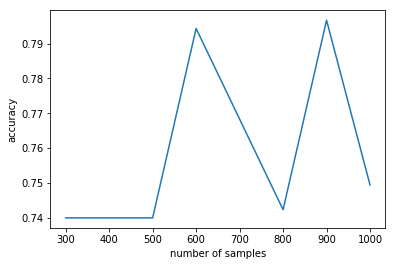

In [53]:
fig = plt.figure()
ax = plt.axes()

plt.xlabel('number of samples')
plt.ylabel('accuracy')
ax.plot(number_of_samples, accuracies);


# Results

In [171]:
shallow_model_results = shallow_model.evaluate(X_test, y_test, batch_size=128)
deep_model_results = deep_model.evaluate(X_test, y_test, batch_size=128)
deep_aug_model_results = deep_aug_model.evaluate(X_test, y_test, batch_size=128)


print('\n# Evaluate on test data')
print('Shallow model test loss, test acc:', shallow_model_results)
print('Deep model test loss, test acc:', deep_model_results)
print('Deep model with augmentations test loss, test acc:', deep_aug_model_results)

443/443 [==============================] - 1s 2ms/sample - loss: 1.0087 - acc: 0.5937

# Evaluate on test data
Shallow model test loss, test acc: [1.0690552577477277, 0.5598194]
Deep model test loss, test acc: [6.3275180401167, 0.37020317]
Deep model with augmentations test loss, test acc: [1.0086767906260006, 0.5936795]
